Loading Vision Model...
Model loaded successfully.


0: 800x1024 10 grade headerss, 5 grade tables, 5 singe row tables, 180.7ms
Speed: 4.1ms preprocess, 180.7ms inference, 0.8ms postprocess per image at shape (1, 3, 800, 1024)


Image path: /Users/declanbracken/Development/UofT_Projects/Meng_Project/Transcripts/Web_Scraped_Transcripts/2015-queens-university-transcript-1-2048.webp


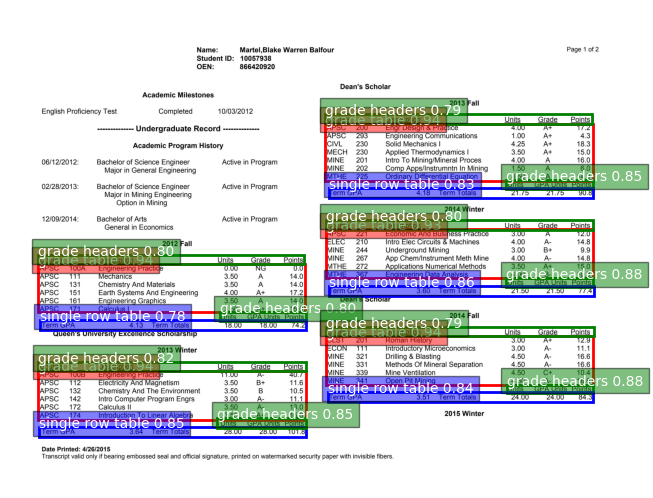

In [1]:
import sys

# Manually specify the path to the parent directory
parent_dir = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/code_base'  # Replace this with the path where 'Pipelines' is located
sys.path.append(parent_dir)

# Import vision_pipeline from Pipelines
from Pipelines.vision_pipeline import vision_pipeline

# Step 1: Import Classes
from image_processor import ImageProcessor
from text_classifier import TextClassifier
from row_clusterer import RowClassifier
from dataframe_processor import DataFrameProcessor
from visualizer import Visualizer

# Step 2: Load Example Image and Model Results
image_directory = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/Transcripts/Web_Scraped_Transcripts/'
image_name = '2015-queens-university-transcript-1-2048.webp'
image_path = image_directory + image_name

model_path = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/code_base/yolo_training/yolo_v8_models/finetune_v5/best.pt'
pipeline = vision_pipeline(model_path)
results = pipeline.predict(image_path, plot = True, iou = 0.3, conf = 0.5, agnostic_nms = True)


In [2]:

# Step 3: Initialize ImageProcessor and Check Cropped Images
image_processor = ImageProcessor(image_path, results[0].boxes.data.cpu().numpy())
cropped_images = image_processor.cropped_images
boxes = image_processor.boxes
print(f"Number of cropped images: {len(cropped_images)}")
# Step 4: Initialize TextClassifier and Classify Text
text_classifier = TextClassifier(cropped_images, results[0].boxes.cls.cpu().numpy(), boxes)
text_classifier.classify_text()


Number of cropped images: 20


In [15]:
import numpy as np
# Step 5: Initialize RowClassifier and Cluster Rows
row_classifier = RowClassifier(text_classifier.headers, text_classifier.single_row, text_classifier.tables)
all_rows = row_classifier.collect_all_rows()
# print("ALL ROWS:", all_rows)
row_features = row_classifier.create_binary_heatmap_features(all_rows)
print(row_features[30])

labels = row_classifier.cluster_lines_with_positions(row_features)
# all_rows = row_classifier.classify_rows(eps = 2000)
# print(f"Number of clustered rows: {len(all_rows)}")

# Step 6: Initialize DataFrameProcessor and Process Rows to DataFrame
# df_processor = DataFrameProcessor()
# final_df = df_processor.process_tables_to_dataframe(all_rows)

# # Step 7: Visualize Final Results
# visualizer = Visualizer()
# visualizer.plot_dataframe(final_df)  # Replace with your DataFrame plotting function


[          1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1
           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1
           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           0           0           0           0           0           0           0
           0           0           0           0           0 

In [14]:
print(all_rows)

[{'box': [], 'text': {'left': [0, 7, 7, 7], 'top': [0, 6, 6, 6], 'width': [287, 274, 274, 274], 'height': [28, 18, 18, 18], 'text': ['', '', '', '']}}, {'box': [], 'text': {'left': [0, 5, 5, 5], 'top': [0, 6, 6, 6], 'width': [285, 274, 274, 274], 'height': [28, 17, 17, 17], 'text': ['', '', '', '']}}, {'box': [], 'text': {'left': [0, 7, 7, 7], 'top': [0, 7, 7, 7], 'width': [288, 274, 274, 274], 'height': [29, 17, 17, 17], 'text': ['', '', '', '']}}, {'box': [], 'text': {'left': [0, 14, 14, 14], 'top': [0, 8, 8, 8], 'width': [294, 274, 274, 274], 'height': [30, 18, 18, 18], 'text': ['', '', '', '']}}, {'box': [], 'text': {'left': [0, 7, 7, 7, 7, 202], 'top': [0, 2, 2, 2, 6, 2], 'width': [883, 868, 868, 868, 73, 113], 'height': [28, 26, 26, 26, 18, 26], 'text': ['', '', '', '', 'Course', 'Description']}}, {'box': [], 'text': {'left': [0, 6, 6, 6, 6], 'top': [0, 6, 6, 6, 10], 'width': [881, 868, 868, 868, 73], 'height': [31, 25, 25, 25, 17], 'text': ['', '', '', '', 'Course']}}, {'box': [